In [1]:
import matplotlib.pyplot as plt
from config import settings

import pymongo
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.size'] = 25

# db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']
db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan30_encoding_preset']

In [2]:
approach1 = 'backprop_sigmoid_saliency_error_add_preset_lr_0.1'
approach2 = 'chameleon'

0.5635548397898674
0.7772133688131968


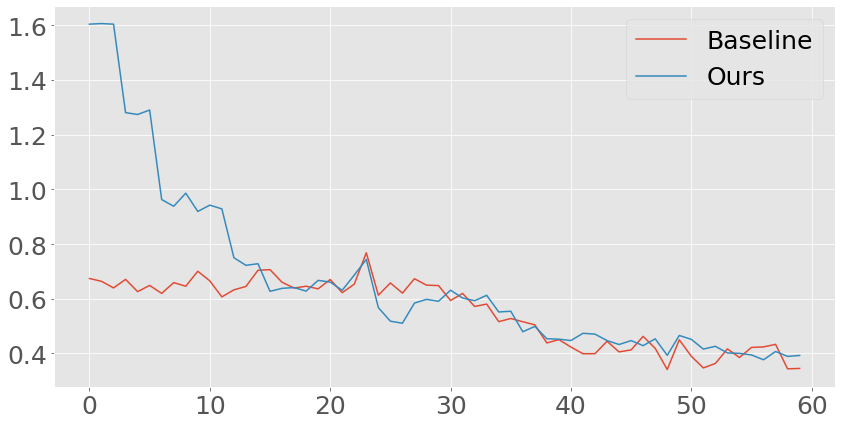

In [3]:


import numpy as np
def query_approach(ax, approach, label, column='stats', key='f1'):
    f1s = []

    for sec in range(1, 61):

        query = {
            'second': sec,
            'command_line_args.approach': approach,
        }

        x = list(db['stats'].find(query))
        x = sorted(x, key = lambda x: x['_id'])
        f1s.append(x[-1])



    ax.plot(range(len(f1s)), [1 - i['f1'] \
        + settings.backprop.bw_weight * i['norm_bw'] \
            + settings.backprop.compute_weight * len(i['encoded_frames'])/10 for i in f1s], label=label)
    print(np.array([i[key] for i in f1s]).mean())
    

fig, ax = plt.subplots(figsize=(14, 7))
query_approach(ax, approach2, 'Baseline')
query_approach(ax, approach1, 'Ours')
# query_approach(ax, approach3, 'Cheat')

ax.legend()

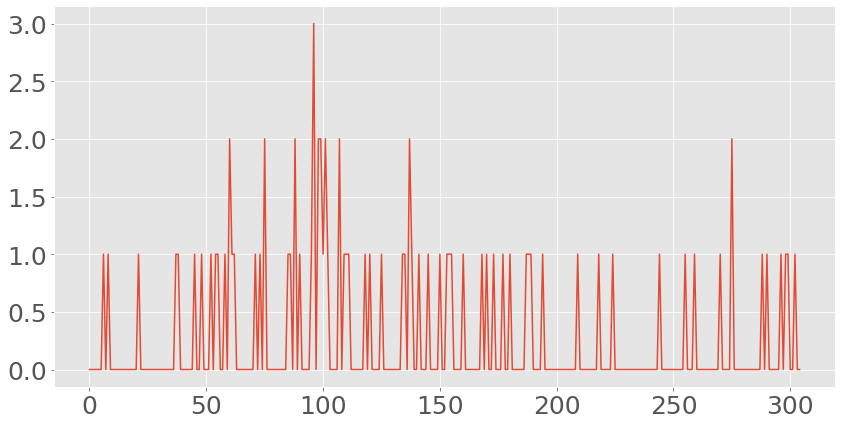

In [36]:
fig, ax = plt.subplots(figsize=(14, 7))
hidden_fns = list(db['Hidden_FP'].find())
hidden_fns = [i['count'] for i in hidden_fns]
ax.plot(hidden_fns)